# Maps in shapefile and JSON format

This notebook explores the potential of "shapefile" maps based on the "polygonfile" library

Contents:
1. Basic map information loaded from official sources (e.g. Eurostat) in shapefile format. This procedure may load much more data than is actually needed (e.g. a country may be composed by a number of small shapes that are not relevant for the application; we may be interested in a small number of coutntries...)

2. A basic code to plot a map controlling border and fill color (from SHAPEFILE)

3. Filter the dataset (e.g. only some selected countries) and save in JSON format for further use 

4. An efficient function to plot a map controlling border and fill color  (from JSON)

 



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load base map from JSON

In [5]:
file=r"./maps/ITA/Italia_geo.json"

from pandas_geojson import read_geojson, filter_geojson
geo_json = read_geojson(file)
geo_json['type']


'FeatureCollection'

In [6]:
#geo_json['features'][0]

In [7]:
import pandas as pd
nn = len(geo_json['features'])
cols = [  'istat_r', 'istat_p','istat_c','nome', 'poly']
df = pd.DataFrame(columns=cols)
for i in range(nn):
    new_row = {'istat_r' : geo_json['features'][i]['properties']['reg_istat_code'], 
                'istat_p': geo_json['features'][i]['properties']['prov_istat_code'],
                'istat_c': geo_json['features'][i]['properties']['com_istat_code'],
                'nome'   : geo_json['features'][i]['properties']['name'],
                'poly'   : geo_json['features'][i]['geometry']['coordinates'][0][0]}
                   # consider only firs polygon  
         
    df = df.append(new_row, ignore_index = True)


In [8]:
df=df[ df.istat_r=='06']

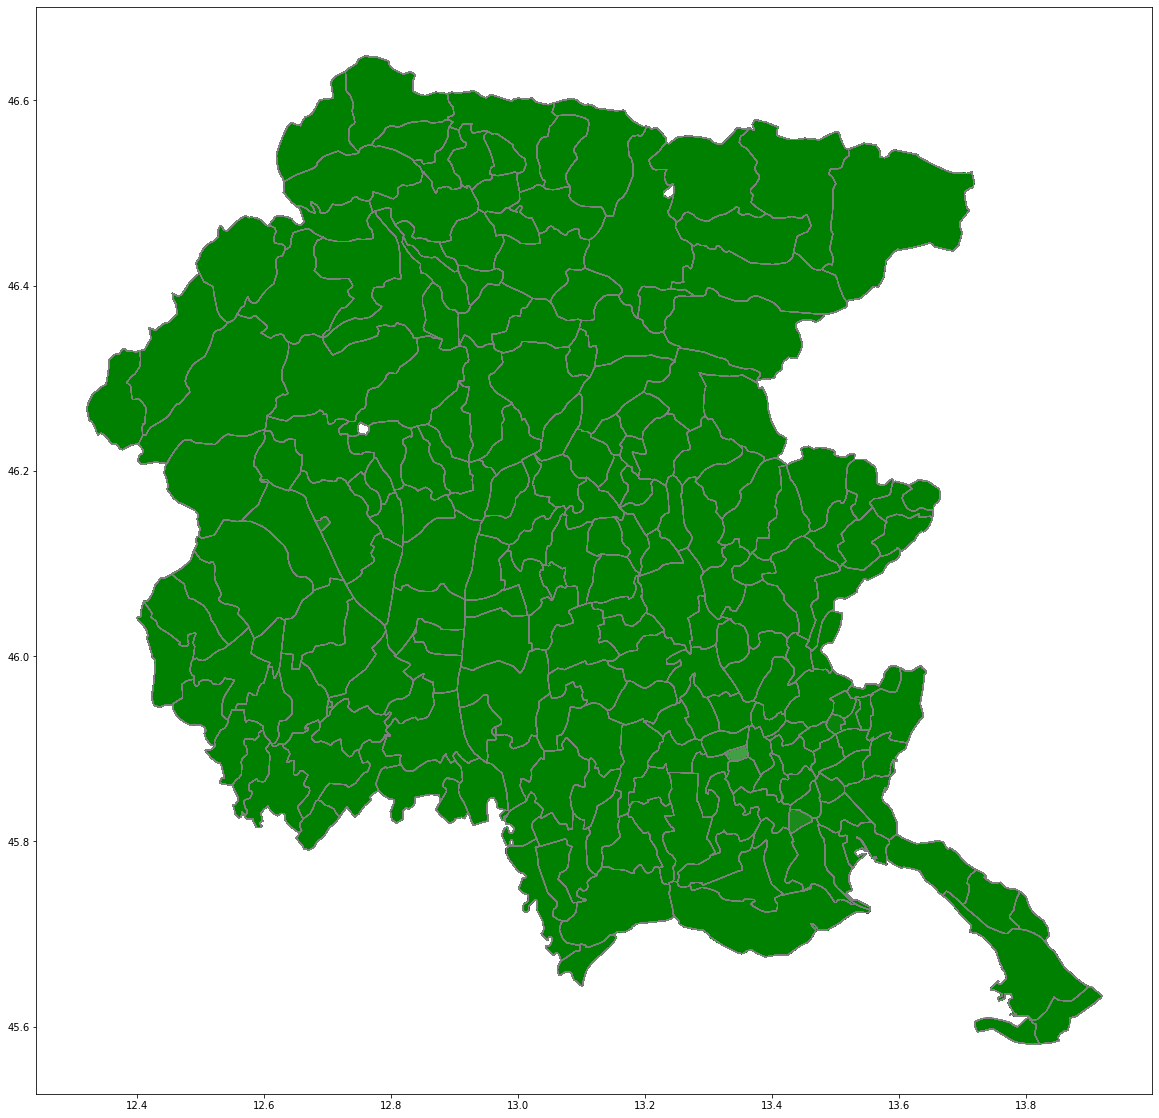

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
for index, row in df.iterrows():
    for p in range(len(row.poly)):
        x, y = list(zip(*row.poly)) 
        plt.plot(x,y, color = "gray", linewidth=.8)
        plt.fill(x,y, color = "green", alpha = .1)
plt.show()

In [10]:
df.to_json('FVG_sfondo.json', orient='records')

In [11]:
codes1 = pd.read_csv(r"./maps/NUTS_AT_2021.csv", usecols=["CNTR_CODE","NUTS_ID", "NAME_LATN"])
codes1 = codes1[ codes1.CNTR_CODE == "IT"] 
codes1['prov']=codes1['NUTS_ID'][:4]
codes1 #= codes1[ codes1.prov == "ITH4"] 

codes1

FileNotFoundError: [Errno 2] No such file or directory: './maps/NUTS_AT_2021.csv'

In [ ]:
file=r"./maps/NUTS_BN_01M_2021_4326_LEVL_3.geojson"

from pandas_geojson import read_geojson, filter_geojson
geo_json = read_geojson(file)

#https://pypi.org/project/pandas-geojson/?msclkid=05bdafe0b06911ecbb0500c852af722c

 
geo_json['type']


In [ ]:
len(geo_json['features'])

In [ ]:
geo_json['features'][0]['properties']

In [ ]:
coords = geo_json['features'][0]['geometry']['coordinates']

In [ ]:
x = list(zip(*coords))[0]
y = list(zip(*coords))[1]

In [ ]:
x

In [ ]:
y

# Load data on italian minicipalities and regions

In [ ]:
df = pd.read_csv('./data/Elenco-comuni-italiani.csv', sep=";", dtype='str')
cols_to_use = ['Codice Regione', 'Codice Comune formato alfanumerico' ,'Denominazione in italiano']
df = df[ cols_to_use ]
df.columns = ['cod_regione', 'cod_comune', 'nome_comune']
df = df[ df['cod_regione']== '06' ] # regione FVG
selected_codes = df.cod_comune.to_list()

#df

In [ ]:
    points = pd.read_csv('./data/comuni_lat_long.csv', sep=";")
    x = points.lng
    y = points.lat
    plt.scatter(x=x, y=y,s=2, c="black", marker=".")
     

In [ ]:
nbins=10
radius= (x.max()-x.min())
print(radius)
points = np.array(list(zip(x,y)))
points = points[:10]
points

In [ ]:
import scipy.spatial as spatial

point_tree = spatial.cKDTree(points)
# This finds the index of all points within  radius
radius=100
idx=point_tree.query_ball_point(points, radius)
idx
 # This gives the point in the KDTree which is within radius 
points= point_tree.data[point_tree.query_ball_point(points, radius)]

 

In [ ]:

xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
xi, yi = np.mgrid[x.min():x.max():nbins, y.min():y.max():nbins]
for i in range(nbins):
    for j in range(nbins):
        pass#print(xi[i], yi[i])

#zi = (np.vstack([x,y]))
#data_to_plot = zi.reshape(xi.shape)


In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
axes.pcolormesh(x, y, data_to_plot,  cmap="RdYlBu")#, vmin=0.005, vmax=10)
axes.set_title('2D Density with shading + threshold + scatter' )
axes.scatter(x, y, s=5, color="black")

# load data from shapefile .shp

In [ ]:
import shapefile as shp

#local path:  maps\ITA\Com01012022\Com01012022_WGS84.shp
shp_path = r"./maps/ITA/Com01012022/Com01012022_WGS84.shp"
sf = shp.Reader(shp_path)
shapeRecs = sf.shapeRecords()
n_shapes = len(shapeRecs)
print("Number of shapes loades: ",n_shapes)


In [ ]:
data_to_plot = pd.DataFrame(columns = ['code', 'name', 'xc','yc','polygon'])

for sh_id in range(n_shapes):
        code = shapeRecs[sh_id].record[6]
        
        if code in selected_codes:

                new_row = {     'code':  code, 
                                'name': shapeRecs[sh_id].record[7],
                                'xc':   shapeRecs[sh_id].record[10],
                                'yc':   shapeRecs[sh_id].record[11],
                                'polygon': sf.shape(sh_id).points[:]}
                        
                data_to_plot = data_to_plot.append(new_row, ignore_index = True)

     
data_to_plot

In [ ]:
for index, row in data_to_plot.iterrows():
    coords = list(zip(*row.polygon))
    
    plt.plot(coords[0],coords[1], c="white")
    plt.fill(coords[0],coords[1], c="gray", alpha=1)


plt.show()


In [ ]:

from pyproj import Transformer
transformer = Transformer.from_crs("epsg:3857","epsg:4326")

fix,ax = plt.subplots(figsize=(20,20))
for index, row in data_to_plot.iterrows():
    coords = list(zip(*row.polygon))
    y = np.array(coords[0])
    y = (y +500000)/0.9996
    x = np.array(coords[1])
    x=x/0.9996
    lon, lat = transformer.transform(x, y)
    plt.plot(lon,lat, c="white",linewidth=0.5)
    plt.fill(lon,lat, c="gray", alpha=1)
    

 